In [1]:
import pandas as pd
import os
import json
import torch
import numpy as np
from steams.data import KVyQVx
from steams.models.attention import madsnn3
from steams.trainer import AttentionTrainer,train, evaluation, prediction_prime, ensemble_prime
from steams.criterion import R2,RMSE,variance
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import geopandas as gpd

In [2]:
parent_dir = os.path.abspath(os.path.join(os.path.abspath(os.getcwd()), os.pardir))

In [3]:
resdir = os.path.join(parent_dir,'results')
figdir = os.path.join(parent_dir,'fig')
if not os.path.exists(figdir):
    os.makedirs(figdir)
if not os.path.exists(resdir):
    os.makedirs(resdir)

In [4]:
if torch.cuda.is_available():
    cuda_name = "1"
    num_workers=0
    pin_memory = True
    device = torch.device('cuda'+":"+cuda_name)
    #device = torch.device('cuda')
else:
    num_workers = 4
    pin_memory = False
    device = torch.device('cpu')

In [5]:
device

device(type='cpu')

## train/valid dataset

In [6]:
params = {
        "class" : "KVyQVx",
        "Y":{
          "path": "",
          "KEY":["x","y"],
          "VALUE": ["sensor_hq"],
          "nb_location" : 1000,
          "history_length": 0,
          "nb_sampling": 100
        },
        "X":{
          "path": "",
          "QUERY":["x","y"],
          "VALUE": ["sensor_hq"],
          "nb_location" : 1000,
          "gap_length": 0,
          "horizon_length":0,
          "nb_sampling": 100
        }
    }

In [7]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_train")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_train")

train_dataset = KVyQVx(params)

In [8]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_valid")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_valid")

valid_dataset = KVyQVx(params)

In [9]:
#train_dataset[0]

## model, optimizer, criterion, scheduler

In [10]:
#model
model = madsnn3(device,type="krig",kernel="exp", input_k=2,input_q=2, input_v=1, hidden_size=32)

In [13]:
# optimzer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #8e-3
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# criterion
criterion = torch.nn.MSELoss()

# AttentionTrainer object
obj = AttentionTrainer(model,device)
obj.init_optimizer(optimizer)
obj.init_criterion(criterion)

## Training

Rem: madsnn3(device,type="krig",kernel="exp", input_k=2,input_q=2, input_v=1, hidden_size=32) is quite sensitive once you reach 'good loss'; As a consequence, the loss might explode, and you will lose the interesting paramaters.
So, I keep niter small, and keep repeating while 'loss'is not satisfying enough. Once reaching nice loss, I change the lr (for instance lr=1e-5)in the previous notebook cell and re-run it, as well as the the train notebook cell.

In [17]:
# training
train(obj,train_dataset,valid_dataset,niter=10,n_iter_stop=20,batch_size=32,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

  epoch     train     valid
0     0  0.404442  0.377261
  epoch     train    valid
0     1  0.408578  0.39928
  epoch     train     valid
0     2  0.388926  0.322377
  epoch     train     valid
0     3  0.358202  0.341259
  epoch     train     valid
0     4  0.383234  0.335242
  epoch     train   valid
0     5  0.382368  0.3648
  epoch     train     valid
0     6  0.376265  0.346255
  epoch     train     valid
0     7  0.376374  0.371989
  epoch    train     valid
0     8  0.37648  0.351751
  epoch     train     valid
0     9  0.398632  0.412977


In [18]:
obj.save_model(resdir,"1c-krignn3")

## Evaluation

In [19]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_eval")

eval_dataset = KVyQVx(params)

In [20]:
criterion = R2()
obj.init_criterion(criterion)

In [21]:
evaluation(obj,eval_dataset,batch_size=32,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

0.028714075684547424


In [22]:
criterion = RMSE()
obj.init_criterion(criterion)

In [23]:
evaluation(obj,eval_dataset,batch_size=32,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

0.32346112933009863


In [24]:
criterion = variance()
obj.init_criterion(criterion)

In [25]:
evaluation(obj,eval_dataset,batch_size=32,shuffle=True,num_workers=num_workers,pin_memory=pin_memory,resdir=None)

0.05059092561714351


## QQplot

In [26]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_eval")

eval_dataset = KVyQVx(params)

In [27]:
results = prediction_prime(obj,eval_dataset)

/home/jean-marie/dev/01-packages/steams_pkg/steams/trainer.py:163: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,tmp_df],ignore_index=True,axis=0)


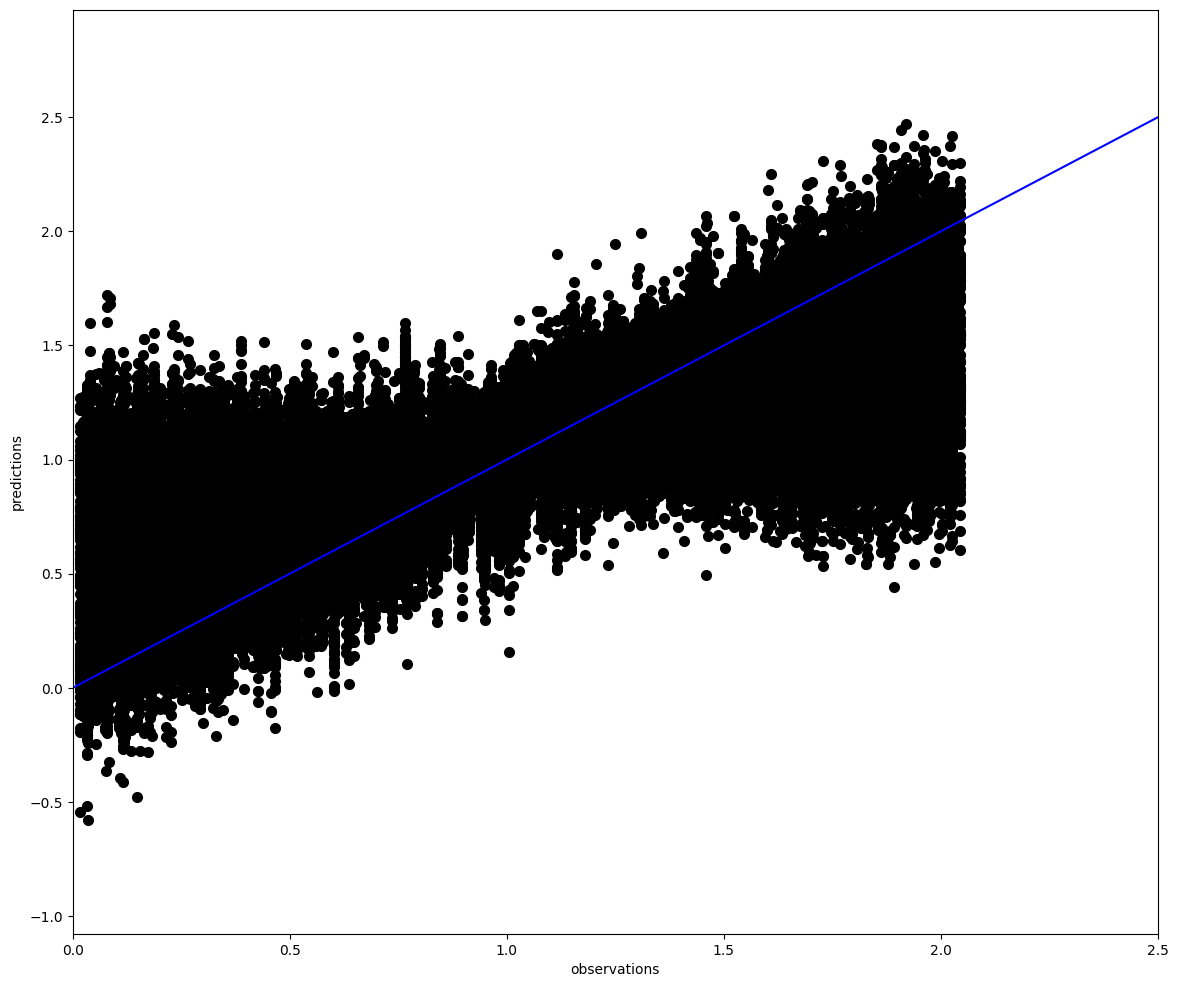

In [28]:
pred_name = ['pred_' + v for v in eval_dataset.VALUE_X]

fig, ax= plt.subplots(figsize=(14, 12))
ax.scatter(results.loc[:,eval_dataset.VALUE_X],results.loc[:,pred_name], linewidth=2.0,c="black")
ax.axline((0, 0), slope=1., color='blue')
ax.set_xlim(0, 2.5)
ax.set_ylim(results.loc[:,pred_name].min().item()-0.5, results.loc[:,pred_name].max().item()+0.5)
ax.set(xlabel='observations', ylabel='predictions')

fig_filename = os.path.join(parent_dir,'fig','1c-qqplot.png')
plt.savefig(fig_filename, dpi = 300)

## Illustration of Wq and Wo on a map

In [42]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_all_6400")
params['X']['nb_location'] = 6400

eval_dataset = KVyQVx(params)

In [44]:
eval_dataset.scale(True)
obj.model.eval()
with torch.no_grad():
    results = pd.DataFrame(columns=['x','y','Wqx','Wqy','Wo'])
    obs=[]
    pred=[]
    for i in range(len(eval_dataset)):
        
        KEY_Y,VALUE_Y,QUERY_X, VALUE_X = eval_dataset[i]
        QUERY_X = QUERY_X.to(obj.device)
    
        # input with dimension batch and on device
        QUERY_X = torch.reshape(QUERY_X,(1,QUERY_X.shape[0],QUERY_X.shape[1]))
        
        Wq = obj.model.Wq(QUERY_X.float() ).detach().cpu().numpy()
        Wo = obj.model.Wo(QUERY_X.float() ).detach().cpu().numpy()
        
        QUERY_X_unscaled = eval_dataset.unscale(QUERY_X.detach(),"QUERY")
        
        tmp = np.concatenate((QUERY_X_unscaled, Wq,Wo),2)
        tmp = np.reshape(tmp,(tmp.shape[1],tmp.shape[2]))
        
        tmp_df = pd.DataFrame(tmp,columns=['x','y','Wqx','Wqy','Wo'])
        
        results = pd.concat([results,tmp_df],ignore_index=True,axis=0)
eval_dataset.scale(False)        

/tmp/ipykernel_10999/160715489.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,tmp_df],ignore_index=True,axis=0)


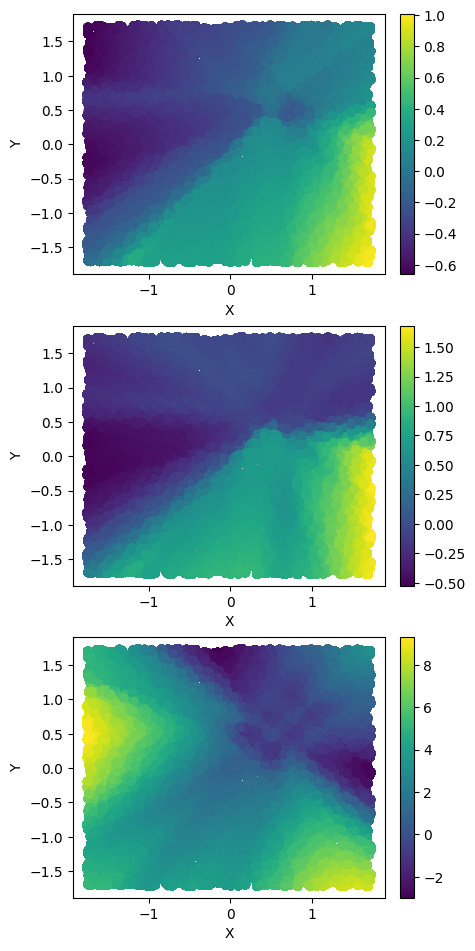

In [45]:
fig = plt.figure(constrained_layout=True,figsize=(14, 12))
gs = GridSpec(4, 4, figure=fig)

ax0 = fig.add_subplot(gs[0,0])
c0 = ax0.scatter(x=results["x"], y=results["y"], c=results["Wqx"], vmax=np.max(results["Wqx"]))
ax0.set(ylabel='Y',xlabel='X')

ax1 = fig.add_subplot(gs[1,0])
c1 = ax1.scatter(x=results["x"], y=results["y"], c=results["Wqy"], vmax=np.max(results["Wqy"]))
ax1.set(ylabel='Y',xlabel='X')

ax2 = fig.add_subplot(gs[2,0])
c2 = ax2.scatter(x=results["x"], y=results["y"], c=results["Wo"], vmax=np.max(results["Wo"]))
ax2.set(ylabel='Y',xlabel='X')


fig.colorbar(c0, ax=ax0)
fig.colorbar(c1, ax=ax1)
fig.colorbar(c2, ax=ax2)

fig_filename = os.path.join(parent_dir,'fig','1c-illustration_W.png')
plt.savefig(fig_filename, dpi = 300)


## ensemble, quantiles and p-value 

In [46]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_1000_X_eval")

eval_dataset = KVyQVx(params)

In [47]:
# !! might take some time
ensemble = ensemble_prime(obj,eval_dataset,N=2)

/home/jean-marie/dev/01-packages/steams_pkg/steams/trainer.py:163: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,tmp_df],ignore_index=True,axis=0)
/home/jean-marie/dev/01-packages/steams_pkg/steams/trainer.py:196: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,prediction_prime(obj,class_data,resdir=None)],ignore_index=True,axis=0)
/home/jean-marie/dev/01-packages/steams_pkg/steams/trainer.py:206: FutureWarning: The provided callable <funct

In [48]:
ensemble.to_csv(os.path.join(resdir,'1c-ensemble.csv'))

### metrics

In [49]:
obs = torch.tensor(ensemble[('sensor_hq', 'mean')].to_numpy())
obs = torch.reshape(obs,(1,obs.shape[0],1))
q0_5 = torch.tensor(ensemble[('pred_sensor_hq','q0_5')].to_numpy())
q0_5 = torch.reshape(q0_5,(1,q0_5.shape[0],1))

In [50]:
criterion = R2()
criterion(obs,q0_5)

tensor(0.3628, dtype=torch.float64)

In [51]:
criterion = RMSE()
criterion(obs,q0_5)

tensor(0.2425, dtype=torch.float64)

In [52]:
criterion = variance()
criterion(obs,q0_5)

tensor(0.0348, dtype=torch.float64)

### qqplot of the observation against the median of the ensemble at each location

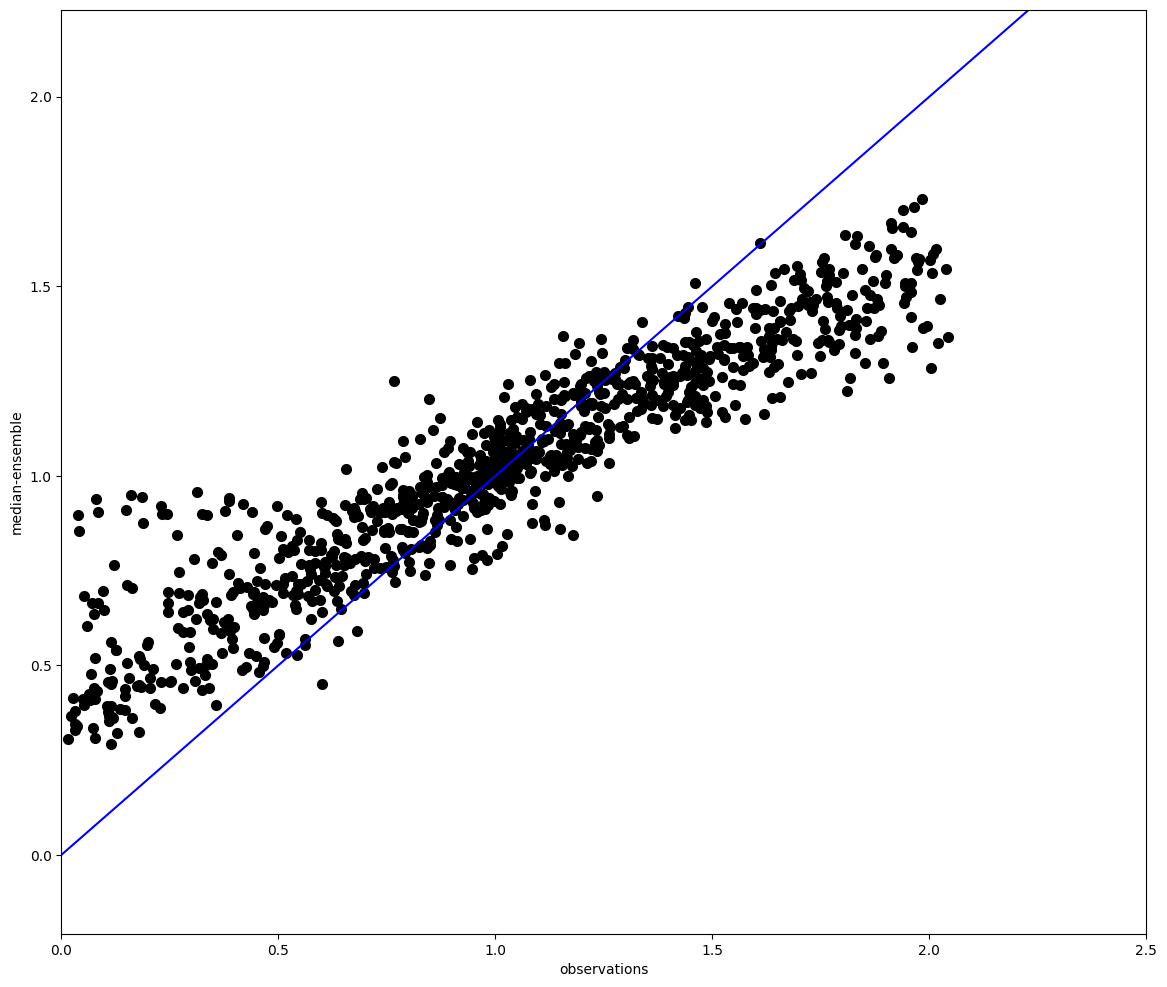

In [53]:
fig, ax= plt.subplots(figsize=(14, 12))
ax.scatter(ensemble[('sensor_hq', 'mean')],ensemble[('pred_sensor_hq','q0_5')], linewidth=2.0,c="black")
ax.axline((0, 0), slope=1., color='blue')
ax.set_xlim(0, 2.5)
ax.set_ylim(ensemble[('pred_sensor_hq','q0_5')].min().item()-0.5, ensemble[('pred_sensor_hq','q0_5')].max().item()+0.5)
ax.set(xlabel='observations', ylabel='median-ensemble')

fig_filename = os.path.join(parent_dir,'fig','1c-ensemble_q0_5_qqplot.png')
plt.savefig(fig_filename, dpi = 300)

### p-qqplot of the p-value of the obsevration within its ensemble against an uniform distribution

In [54]:
ensemble = ensemble.sort_values(by='p_sensor_hq')
ensemble["U"] = np.linspace(0, 1, num=ensemble.shape[0])    

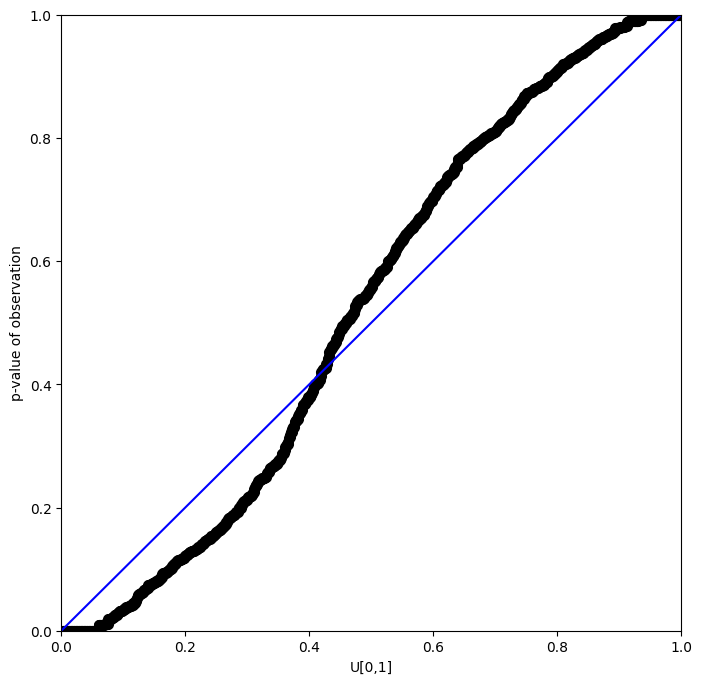

In [55]:
fig, ax= plt.subplots(figsize=(8, 8))
ax.scatter(ensemble['U'],ensemble['p_sensor_hq'], linewidth=2.0,c="black")
ax.axline((0, 0), slope=1., color='blue')
ax.set_xlim(0, 1)
ax.set_ylim(0,1)
ax.set(xlabel='U[0,1]', ylabel='p-value of observation')

fig_filename = os.path.join(parent_dir,'fig','1c-p_qqplot.png')
plt.savefig(fig_filename, dpi = 300)

Signification of the graph: the window of the predicted error is underestimated.

## Illustration of median-quantile 0.05 and median - quantile 0.95 on maps

Purpose: highlight where the model struggles

In [56]:
params['Y']['path'] = os.path.join(parent_dir,"session","synth_1000_Y_eval")
params['X']['path'] = os.path.join(parent_dir,"session","synth_all_6400")
params['X']['nb_location'] = 6400

eval_dataset = KVyQVx(params)

In [57]:
# !! might take some time
ensemble = ensemble_prime(obj,eval_dataset,N=2)

/home/jean-marie/dev/01-packages/steams_pkg/steams/trainer.py:163: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,tmp_df],ignore_index=True,axis=0)
/home/jean-marie/dev/01-packages/steams_pkg/steams/trainer.py:196: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results,prediction_prime(obj,class_data,resdir=None)],ignore_index=True,axis=0)
/home/jean-marie/dev/01-packages/steams_pkg/steams/trainer.py:206: FutureWarning: The provided callable <funct

In [58]:
vmax = np.array(
    np.abs(np.array([ensemble[('pred_sensor_hq','q0_05')] - ensemble[('pred_sensor_hq','q0_5')]])).max(),
    np.array([ensemble[('pred_sensor_hq','q0_95')] - ensemble[('pred_sensor_hq','q0_5')]]).max()).max()


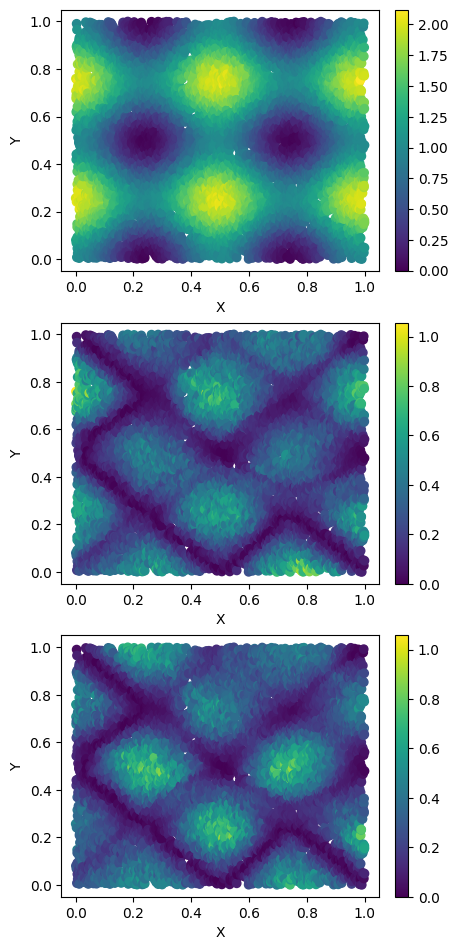

In [59]:
fig = plt.figure(constrained_layout=True,figsize=(14, 12))
gs = GridSpec(4, 4, figure=fig)

ax0 = fig.add_subplot(gs[0,0])
c0 = ax0.scatter(x=ensemble["x"], y=ensemble["y"], c=ensemble[('sensor_hq', 'mean')])
ax0.set(ylabel='Y',xlabel='X')

ax1 = fig.add_subplot(gs[1,0])
c1 = ax1.scatter(x=ensemble["x"], y=ensemble["y"], c=np.abs(ensemble[('pred_sensor_hq', 'q0_05')]- ensemble[('pred_sensor_hq', 'q0_5')]), vmin = 0, vmax=vmax)
ax1.set(ylabel='Y',xlabel='X')

ax2 = fig.add_subplot(gs[2,0])
c2 = ax2.scatter(x=ensemble["x"], y=ensemble["y"], c=ensemble[('pred_sensor_hq', 'q0_95')] - ensemble[('pred_sensor_hq', 'q0_5')], vmin = 0, vmax=vmax)
ax2.set(ylabel='Y',xlabel='X')


fig.colorbar(c0, ax=ax0)
fig.colorbar(c1, ax=ax1)
fig.colorbar(c2, ax=ax2)

fig_filename = os.path.join(parent_dir,'fig','1c-illustration_diff_median-q005_and_median-q095.png')
plt.savefig(fig_filename, dpi = 300)
